<a href="https://colab.research.google.com/github/Christian-F-Badillo/spaceship_kaggle_competition/blob/main/Spaceship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Competititon

Notebook for the spaceship competition.

- The goal it's apply in a simple dataset different machine learning algorithms.

> Author: [Christian Badillo](https://github.com/Christian-F-Badillo/).

## Simple EDA

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn

### Helper Functions

In [349]:
# @title Preprocessing Functions
def dummie_target(df: pd.DataFrame, target_name: str):
    values = df[target_name].dropna().unique()
    dummies = np.arange(0, len(values))
    dummie_list = []

    for i in df[target_name]:
        if pd.isnull(i):
            dummie_list.append(np.nan)
            continue

        for dum in dummies:
            if i == values[dum]:
                dummie_list.append(dum)

    return dummie_list

def family_members(df: pd.DataFrame, column: str):
    names = df[column].dropna().unique()
    members = np.repeat(-1.0, len(names))

    family_dic = {i[0]:i[1] for i in zip(names, members)}
    family = []

    for last in df[column]:
        for number in range(len(names)):
            if last == names[number]:
                family_dic[last] += 1
            else:
                continue

    for i in df[column]:
        if pd.isnull(i):
            family.append(np.nan)
        else:
            for j in family_dic.keys():
                if i == j:
                    family.append(family_dic[j])

    return pd.Series(family, name = 'Family Members')

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

def shuffle_and_split_data(X, y, ratio, seed):
  """
  Helper function to shuffle and split incoming data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]

  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(N * ratio)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

### Data Load

In [3]:
url_train = "https://raw.githubusercontent.com/Christian-F-Badillo/spaceship_kaggle_competition/main/spaceship-titanic/train.csv"
url_test = "https://raw.githubusercontent.com/Christian-F-Badillo/spaceship_kaggle_competition/main/spaceship-titanic/test.csv"

train_data = pd.read_csv(url_train)
test_data = pd.read_csv(url_test)

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
train_data.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
train_drop_na = train_data.dropna()
train_drop_na.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True
11,0008_03,Europa,False,B/1/P,55 Cancri e,45.0,False,39.0,7295.0,589.0,110.0,124.0,Wezena Flatic,True


In [8]:
train_drop_na.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [9]:
train_drop_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6606 non-null   object 
 1   HomePlanet    6606 non-null   object 
 2   CryoSleep     6606 non-null   object 
 3   Cabin         6606 non-null   object 
 4   Destination   6606 non-null   object 
 5   Age           6606 non-null   float64
 6   VIP           6606 non-null   object 
 7   RoomService   6606 non-null   float64
 8   FoodCourt     6606 non-null   float64
 9   ShoppingMall  6606 non-null   float64
 10  Spa           6606 non-null   float64
 11  VRDeck        6606 non-null   float64
 12  Name          6606 non-null   object 
 13  Transported   6606 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 729.0+ KB


In [10]:
ids = train_drop_na.PassengerId
train_drop_na.drop("PassengerId", inplace=True, axis = 1)

<ipython-input-10-2e65c0409b7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_drop_na.drop("PassengerId", inplace=True, axis = 1)


In [11]:
train_data_dummies = train_drop_na.copy()
columns = ["HomePlanet", "VIP", 'Cabin', "CryoSleep", "Destination", 'Transported']
train_data_dummies.reset_index(inplace = True, drop = True)

for i in columns:
    train_data_dummies[i] = dummie_target(train_data_dummies, i)

In [12]:
train_data_dummies.head(8)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,1,0,1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0,0,2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0,0,2,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,1,0,3,0,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1
5,1,0,4,1,44.0,0,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,1
6,1,0,5,0,26.0,0,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,1
7,1,0,6,0,35.0,0,0.0,785.0,17.0,216.0,0.0,Andona Beston,1


In [13]:
train_data_dummies.tail()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6601,0,0,5301,2,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0
6602,1,1,5302,1,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0
6603,1,0,5303,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1
6604,0,0,5304,2,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0
6605,0,0,5304,0,44.0,0,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,1


In [14]:
name_lastname = train_data_dummies.Name.str.split(expand = True)
name_lastname.rename({0: 'Name', 1: 'Last Name'}, inplace = True, axis = 1)
name_lastname.head()

,Name,Last Name
0,Maham,Ofracculy
1,Juanna,Vines
2,Altark,Susent
3,Solam,Susent
4,Willy,Santantines


In [15]:
name_lastname['Last Name'].isna().sum( )

0

In [16]:
print(name_lastname.shape)
print(train_data_dummies.shape)

(6606, 2)
(6606, 13)


In [17]:
members = family_members(name_lastname, "Last Name")

In [285]:
print(members)

0       0
1       0
2       0
3       0
4       0
       ..
6601    0
6602    0
6603    0
6604    1
6605    1
Name: Family Members, Length: 6606, dtype: int64


In [19]:
train_data_dummies.reset_index(inplace=True, drop=True)
train_data_dummies['Family Members'] = members
train_last = train_data_dummies.copy()
train_last.drop('Name', axis = 1, inplace=True)
train_last.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Family Members
0,0,0,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0
1,1,0,1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0
2,0,0,2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0
3,0,0,2,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0
4,1,0,3,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0


In [20]:
train_last.tail()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Family Members
6601,0,0,5301,2,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,0
6602,1,1,5302,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,0
6603,1,0,5303,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,0
6604,0,0,5304,2,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,1
6605,0,0,5304,0,44.0,0,126.0,4688.0,0.0,0.0,12.0,1,1


### Simple Visualization

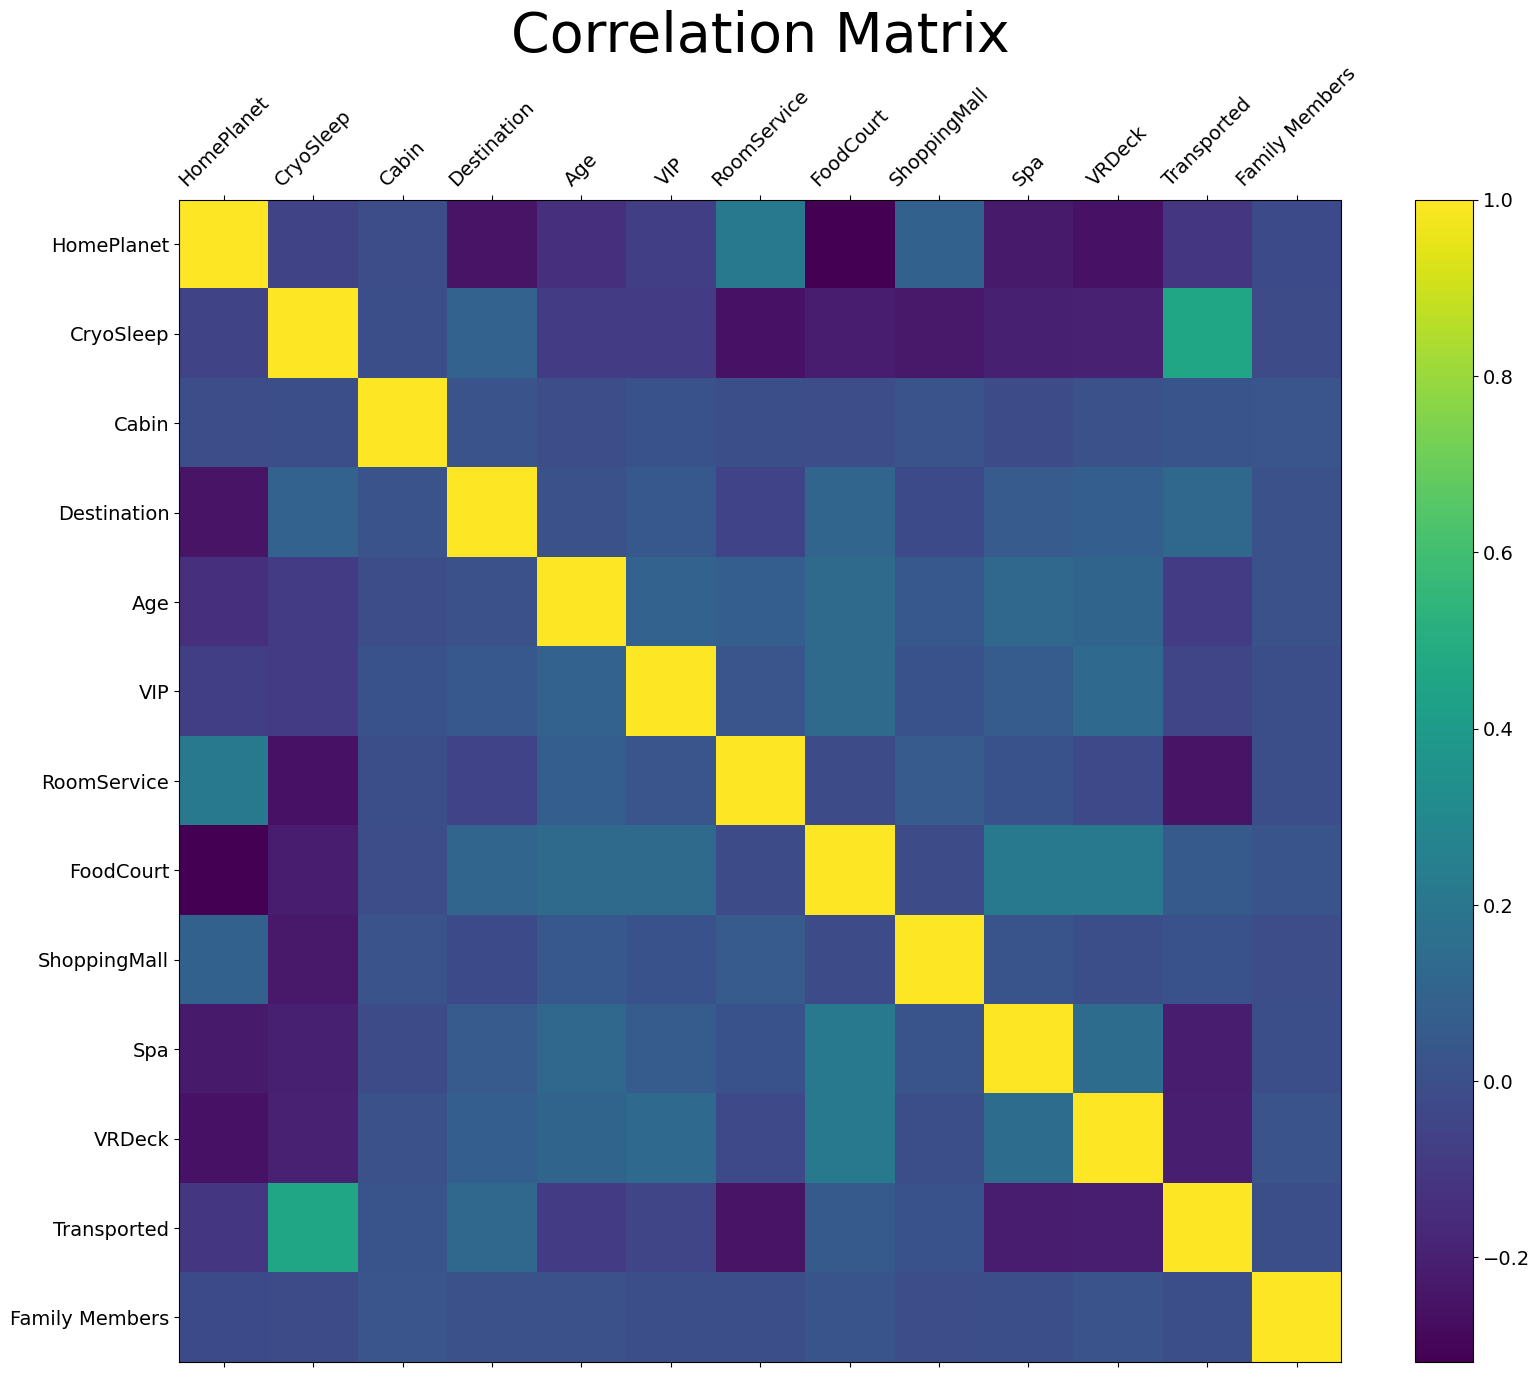

In [21]:
df = train_last

f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=40)
plt.show()

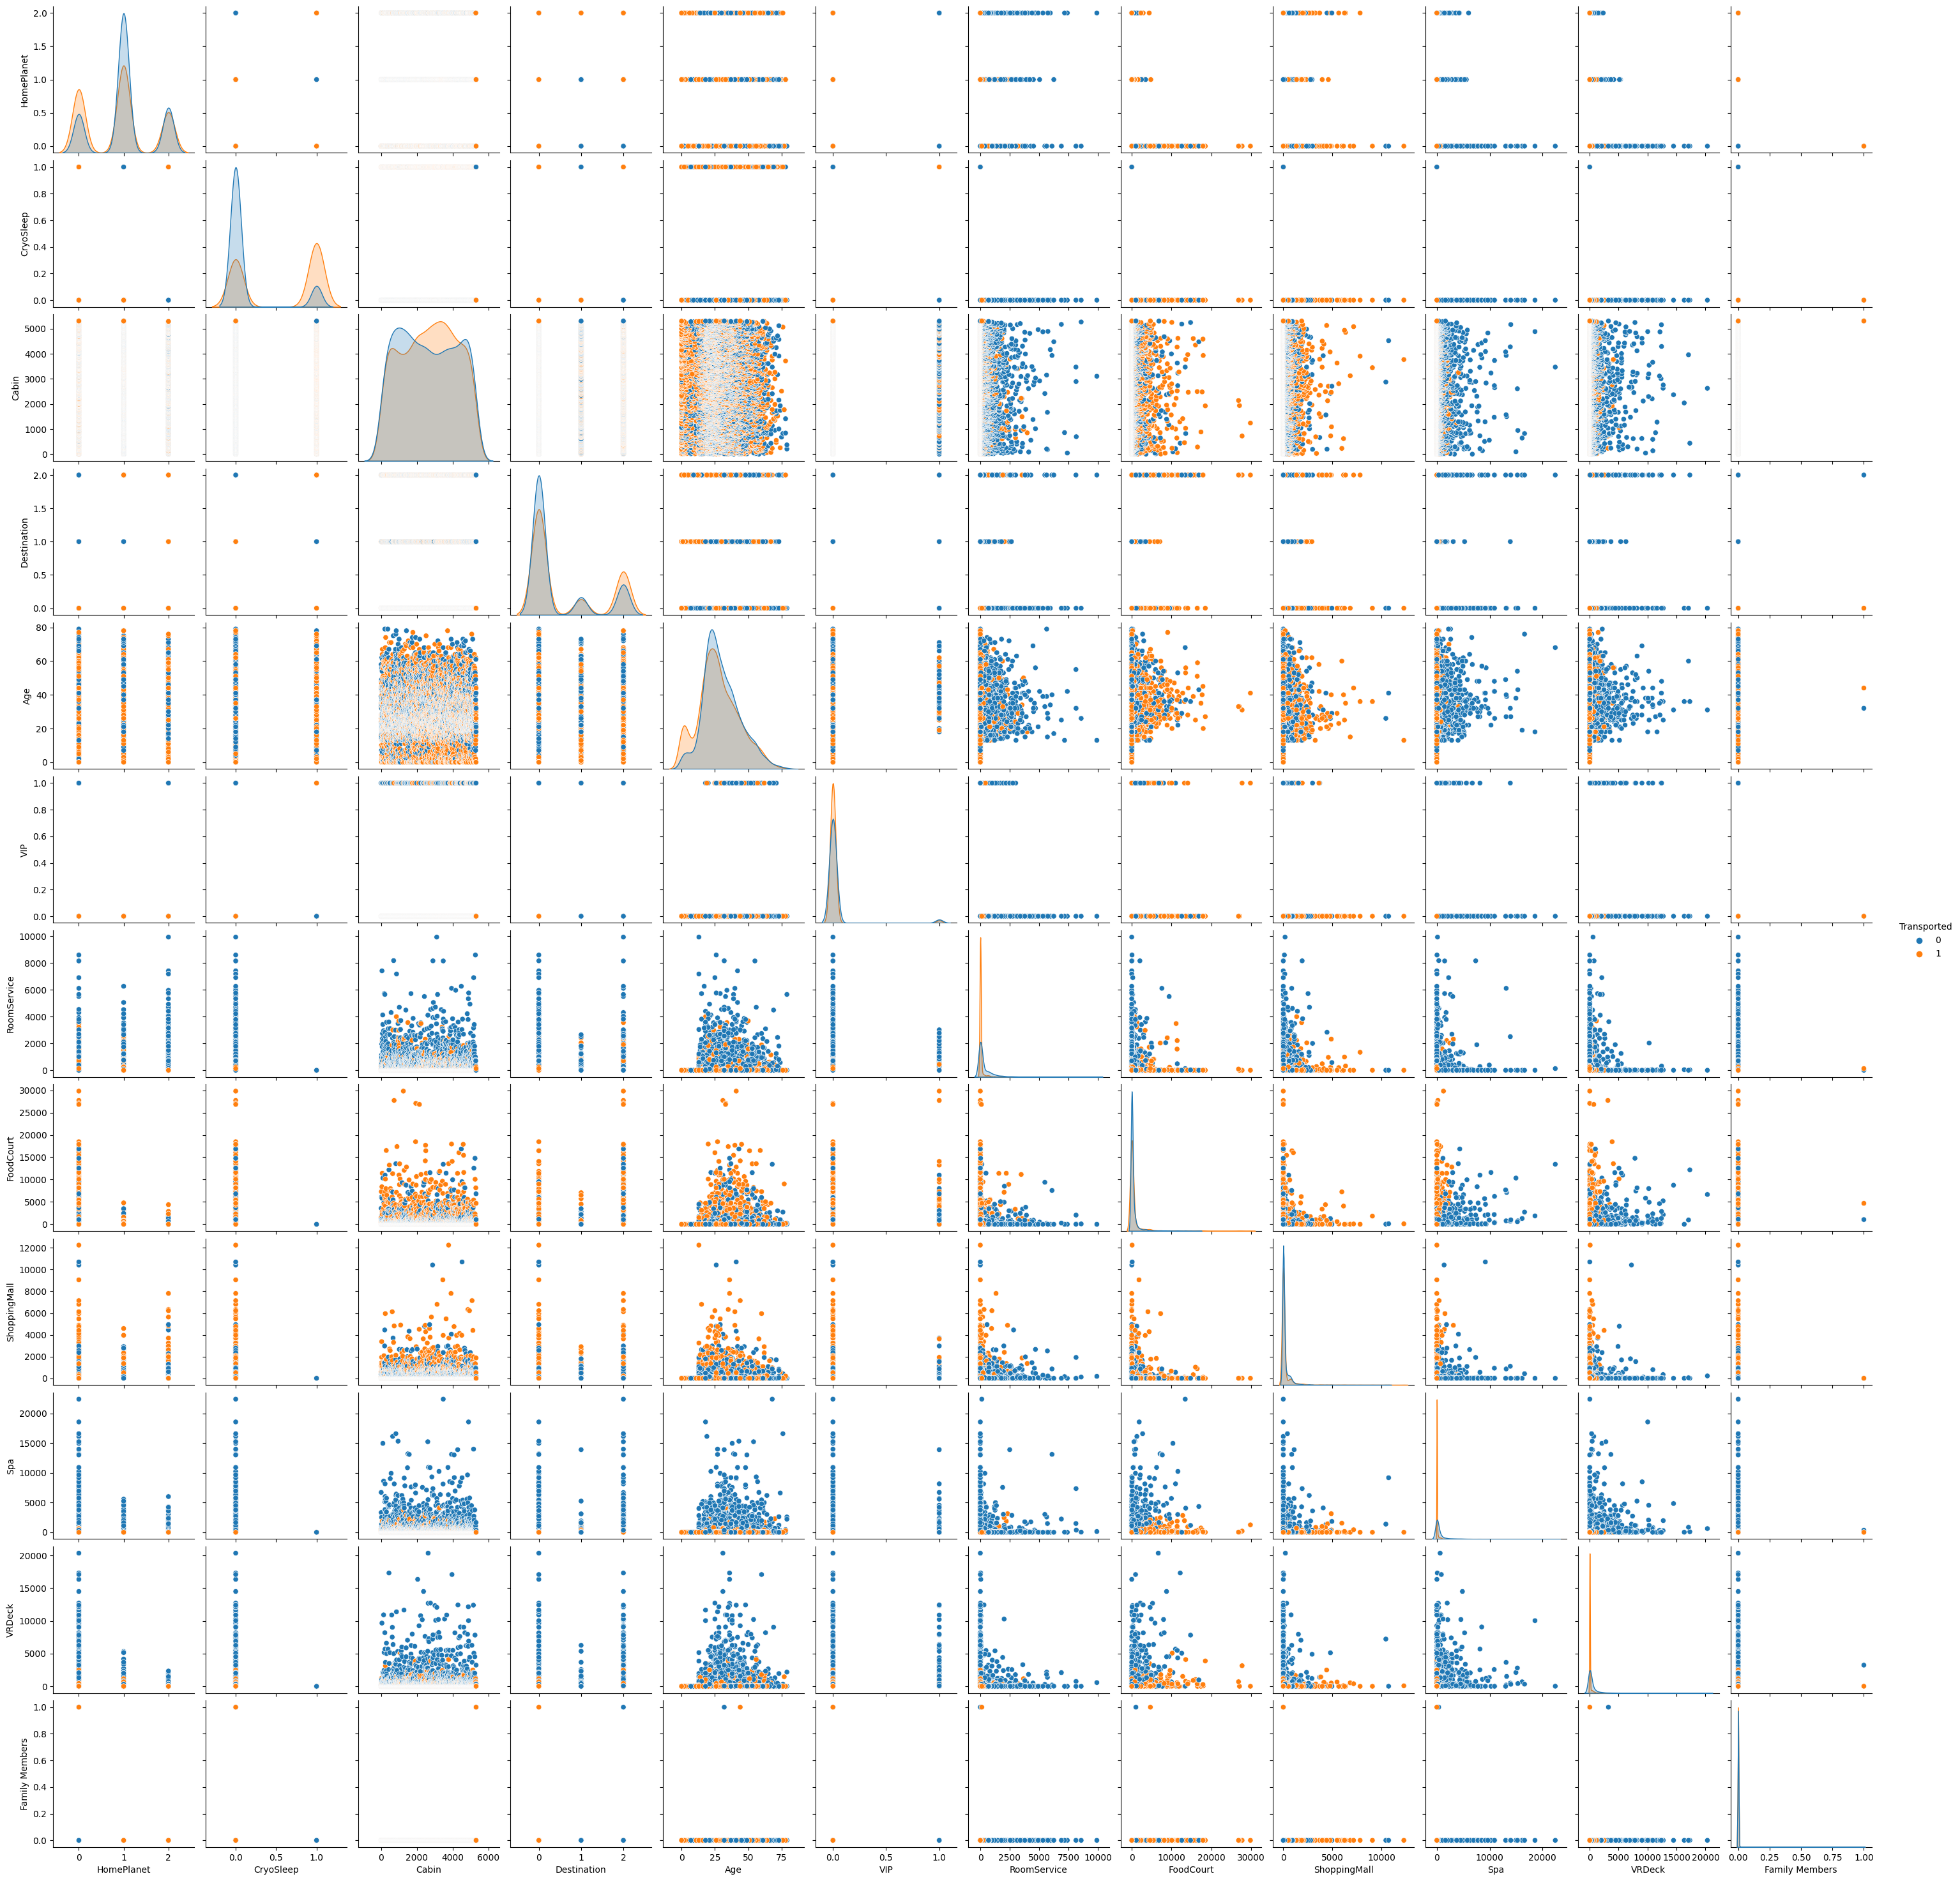

In [22]:
sns.pairplot(df, hue = 'Transported')
plt.show()

## Modelling

In [23]:
X_data = torch.tensor(train_last.drop('Transported', axis = 1).to_numpy())
Y_data = torch.tensor(train_last['Transported'].to_numpy())

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

norm = StandardScaler()
train_norm = norm.fit_transform(X_data)

minmax = MinMaxScaler()
train_minmax = minmax.fit_transform(X_data)

In [194]:
class FFNet(nn.Module):
    """Create a FeedForward Network for Classification Tasks"""
    def __init__(self, input_shape: int, output_shape: int, hidden_units: list, act_function: str, out_activation: str):
        # Instance the super Class
        super().__init__()

        # Create a Sequential Model
        self.model = nn.Sequential()

        self.__input_shape__ = input_shape

        # Add hidhdn units
        for i in range(len(hidden_units)):

            # Ouput units for the n-th layer
            out_number = hidden_units[i]

            # Linear Layer (X @ W + b)
            layer = nn.Linear(input_shape, out_number)

            # The input of the next layer
            input_shape = out_number

            # Add the layer to the model.
            self.model.add_module(f'Layer {i}', layer)

            # Activation Funtion σ(X @ W + b)
            act_fun = eval(f'nn.{act_function}')

            # Add the Activation Function to the Model
            self.model.add_module(f'Activation Function {i}, {act_function}', act_fun)

        # Output Layer
        out_layer = nn.Linear(input_shape, output_shape)
        #Add the Output Layer to the Model
        self.model.add_module('Output Layer', out_layer)
        # Output Activation
        out_act = eval(f'nn.{out_activation}')
        # Add the output Activation Funtion to the model
        self.model.add_module('Output Activation', out_act)

        # Xavier Weight Initialization for each layer.
        for i in range(len(hidden_units) + 2):
            if i % 2 == 0:
                torch.nn.init.xavier_normal_(self.model[i].weight)

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.model(x)
        return x

In [411]:
def train(model, criterion, optimizer, train_data, test_data, num_epochs=1, device='cpu'):
  """ Train a FeedForward Network
  ### Input:
        model: A valid Pytorch Model.
        optimizer: A valid `torch.optimizer`.
        train_data: A `torch.util.data.DataLoader`.
        num_epochs: Number of Epochs to train.
        device: Type of hardware to train the model.

  ### Return:
        training_loss: Training Loss at each epoch.
        loss_validation: Validation Loss at each epoch.
        acc_train: Train Acurracy at each epoch.
        acc_val: Validation Accuracy at each epoch.
  """
  model.train()

  training_loss = []
  acc_val = []
  acc_train = []
  loss_validation = []

  for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_data, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device)#.float()
      labels = labels.to(device)#.long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)

      loss = criterion(outputs, labels)

      correct_training = 0
      total_training = 0
      _, pred_training = torch.max(outputs, 1)
      total_training += labels.size(0)
      correct_training += (pred_training == labels).sum().item()

      loss.backward()
      optimizer.step()

      # Print statistics
    training_loss += [loss.item()]

    model.eval()

    correct = 0
    total = 0
    for data in test_data:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      loss_val = criterion(outputs, labels)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    loss_validation.append(loss_val.item())

    acc_val.append(correct / total)
    acc_train.append(correct_training / total_training)

    lines = '-' *80
    print(f'Epoch: {epoch + 1} \n Training Loss: {loss.item()}  Test Loss: {loss_validation[epoch]} \n total {total} Test Acc: {acc_val[epoch]} Training Acc: {acc_train[epoch]} \n' + lines)

  return training_loss, loss_validation, acc_train, acc_val

In [196]:
X_test, y_test, X_train, y_train = shuffle_and_split_data(X_data, Y_data, 0.2, seed = 2001)

In [197]:
from torch.utils.data import DataLoader, TensorDataset

BATCH = 1024

train_tensor = TensorDataset(X_train, y_train)
test_tensor = TensorDataset(X_test, y_test)

data_train = DataLoader(train_tensor,
                   batch_size= BATCH,
                   shuffle = True)

data_test = DataLoader(test_tensor,
                   batch_size= BATCH,
                   shuffle = True)

In [403]:
num_epochs = 130 # Number of epochs
# hidden_layers =  [10] * 5 # I suggest use this
hidden_layers = [10, 10 , 10 , 9, 5] # This work well
Categories = 2 # Number of Classes
inp_shape = X_train.shape[1] # Number of Variables

model = FFNet(inp_shape, Categories, hidden_layers, 'LeakyReLU(negative_slope = 1e-5)', 'Sigmoid()').to('cpu')

print(model, '\n')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()

history = train(model, criterion, optimizer, data_train, data_test, num_epochs=num_epochs, device='cpu')

FFNet(
  (model): Sequential(
    (Layer 0): Linear(in_features=12, out_features=10, bias=True)
    (Activation Function 0, LeakyReLU(negative_slope = 1e-5)): LeakyReLU(negative_slope=1e-05)
    (Layer 1): Linear(in_features=10, out_features=10, bias=True)
    (Activation Function 1, LeakyReLU(negative_slope = 1e-5)): LeakyReLU(negative_slope=1e-05)
    (Layer 2): Linear(in_features=10, out_features=10, bias=True)
    (Activation Function 2, LeakyReLU(negative_slope = 1e-5)): LeakyReLU(negative_slope=1e-05)
    (Layer 3): Linear(in_features=10, out_features=9, bias=True)
    (Activation Function 3, LeakyReLU(negative_slope = 1e-5)): LeakyReLU(negative_slope=1e-05)
    (Layer 4): Linear(in_features=9, out_features=5, bias=True)
    (Activation Function 4, LeakyReLU(negative_slope = 1e-5)): LeakyReLU(negative_slope=1e-05)
    (Output Layer): Linear(in_features=5, out_features=2, bias=True)
    (Output Activation): Sigmoid()
  )
) 

Epoch: 1 
 Training Loss: 0.6298202276229858  Test Loss:

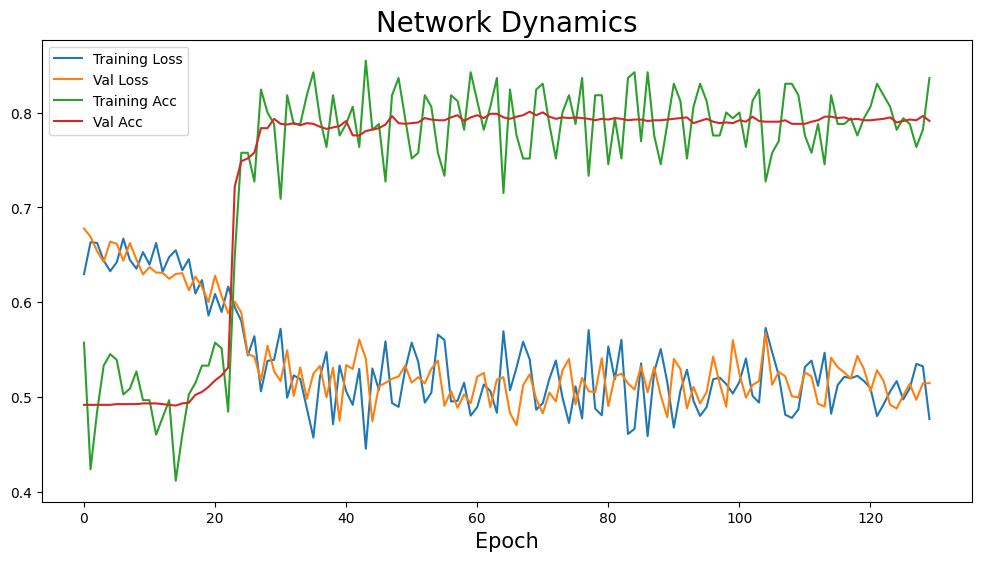

In [404]:
fig, ax = plt.subplots(figsize = (12, 6))

ax.plot(history[0], label = 'Training Loss')
ax.plot(history[1], label = 'Val Loss')
ax.plot(history[2], label = 'Training Acc')
ax.plot(history[3], label = 'Val Acc')

ax.set_xlabel('Epoch', fontsize = 15)
plt.title('Network Dynamics', fontsize = 20)
plt.legend()
plt.show()

## Predictions

In [384]:
def get_predictions(model: None, data: pd.DataFrame):

    data = data.to_numpy()
    data = torch.tensor(data)

    outputs = model(data)
    _, predicted = torch.max(outputs, 1)

    return predicted.tolist()

In [217]:
test_data
test_ids = test_data['PassengerId']
test_drop = test_data.drop('PassengerId', axis = 1)
test_drop.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [220]:
test_drop.isna().sum()

HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [275]:
test_data_dummies = test_drop.copy()
columns = ["HomePlanet", "VIP", 'Cabin', "CryoSleep", "Destination"]

for i in columns:
    test_data_dummies[i] = dummie_target(test_data_dummies, i)

In [276]:
test_data_dummies

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0.0,1.0,1.0,0.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,1.0,0.0,2.0,1.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,1.0,1.0,3.0,0.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0.0,1.0,4.0,0.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.0,0.0,3261.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,0.0,1.0,NaN,0.0,42.0,0.0,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,2.0,0.0,3262.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,1.0,1.0,3263.0,NaN,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [283]:
name_lastname = test_data_dummies.Name.str.split(expand = True)
name_lastname.rename({0: 'Name', 1: 'Last Name'}, inplace = True, axis = 1)
name_lastname.head(5)

,Name,Last Name
0,Nelly,Carsoning
1,Lerome,Peckers
2,Sabih,Unhearfus
3,Meratz,Caltilter
4,Brence,Harperez


In [331]:
print(name_lastname.shape)
print(test_data_dummies.shape)

(4277, 2)
(4277, 13)


In [350]:
members = family_members(name_lastname, "Last Name")
members.shape

(4277,)

In [373]:
test_data_dummies.reset_index(inplace=True, drop=True)
test_data_dummies['Family Members'] = members
test_last = test_data_dummies.copy()
test_last.drop('Name', axis = 1, inplace=True)
test_last.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Family Members
0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,1.0,1.0,0.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,0.0
2,1.0,0.0,2.0,1.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,3.0,0.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,0.0
4,0.0,1.0,4.0,0.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,2.0


In [374]:
for i in test_last.columns:
    test_last[i] = test_last[i].fillna(np.nanmedian(test_last[i]))

In [375]:
test_last.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Family Members
0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,1.0,1.0,0.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,0.0
2,1.0,0.0,2.0,1.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,3.0,0.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,0.0
4,0.0,1.0,4.0,0.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,2.0


In [413]:
Predictions = get_predictions(model, test_last)

In [414]:
print(Predictions[:10])

Predictions = [True if i == 1 else False for i in Predictions]

print(Predictions[:10])

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[True, False, True, True, True, True, True, True, True, True]


In [397]:
predictions_dic = {'PassengerId': test_ids, 'Transported': Predictions}
predictions_df = pd.DataFrame(predictions_dic)
predictions_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [400]:
predictions_df.to_csv('Model_1_predictions.csv', index_label = False, index = False)